In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [4]:
# Data Loader
csf_data = pd.read_csv("merged_csf_cross_sectional_call_rate_pau_data_0205.xls", low_memory=False)
plasma_data = pd.read_csv("merged_plasma_cross_sectional_call_rate_data_0130.xls", low_memory=False)

In [5]:
plasma_data['Status_at_draw_mapping'].value_counts()

Status_at_draw_mapping
CO     1282
AD      865
PD      687
DLB     122
FTD      44
Name: count, dtype: int64

In [6]:
# plasma_data

In [7]:
csf_significant_rows = pd.read_csv("csf_significant_rows_0205.csv")
plasma_significant_rows = pd.read_csv("plasma_significant_rows_0203.csv")

### Data Loader

In [33]:
data = csf_data.copy()
print(data.shape)

(4677, 3667)


In [34]:
x_columns = [col for col in csf_data.columns if col.startswith('X')]
len(x_columns)

3622

In [35]:
protein_list = list(csf_significant_rows['Analytes'])
print(len(protein_list))
# protein_list

3020


In [36]:
data['Status_at_draw_mapping'].value_counts()

Status_at_draw_mapping
AD     744
PD     738
CO     665
FTD     46
DLB     37
Name: count, dtype: int64

In [37]:
data['Project_y'].value_counts()

Project_y
PPMI        1075
MAP         1055
ADNI         737
Ruiz         620
DIAN         482
Stanford     264
PD           238
Pau          206
Name: count, dtype: int64

In [38]:
statuses_to_keep = ['CO', 'AD', 'PD', 'FTD', 'DLB']

filtered_data = data[data['Status_at_draw_mapping'].isin(statuses_to_keep)]
 
filtered_data.shape

(2230, 3667)

In [39]:
filtered_data['Project_y'].value_counts()

Project_y
PPMI        627
MAP         451
Ruiz        448
ADNI        349
PD          158
Pau         110
Stanford     87
Name: count, dtype: int64

In [40]:
filtered_data['Status_at_draw_mapping'].value_counts()

Status_at_draw_mapping
AD     744
PD     738
CO     665
FTD     46
DLB     37
Name: count, dtype: int64

In [41]:
filtered_data = filtered_data.rename(columns={'final_decision': 'PET_imaging'})

columns_to_keep = ['UniquePhenoID', 'DrawDate', 'Project_x', 'Project_y', 'Age_at_draw', 'Sex', 'AT_class', 'PET_imaging', 'T1_pTau217',
       'T2_pTau181', 'Status_at_draw_mapping', 'Status_at_draw', 'Final_Status']
print(columns_to_keep)

selected_protein_columns = [col for col in data.columns if col in protein_list]

selected_columns = list(columns_to_keep) + selected_protein_columns

selected_data = filtered_data[selected_columns]

selected_data.shape

['UniquePhenoID', 'DrawDate', 'Project_x', 'Project_y', 'Age_at_draw', 'Sex', 'AT_class', 'PET_imaging', 'T1_pTau217', 'T2_pTau181', 'Status_at_draw_mapping', 'Status_at_draw', 'Final_Status']


(2230, 3033)

In [42]:
# Check which columns contain non-float values
non_float_columns = selected_data.iloc[:,13:].applymap(lambda x: isinstance(x, (float, int))).all() == False
non_float_columns_indices = non_float_columns[non_float_columns].index

if not non_float_columns_indices.empty:
    print(f"Columns with non-float values: {list(non_float_columns_indices)}")
else:
    print("All columns are float type.")

C:\Users\x.ying1\AppData\Local\Temp\ipykernel_6448\3170815002.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_float_columns = selected_data.iloc[:,13:].applymap(lambda x: isinstance(x, (float, int))).all() == False


All columns are float type.


In [43]:
# Check for NA values in selected_data
na_counts = selected_data.iloc[:,13:].isna().sum()

# Get columns with NA values
na_columns = na_counts[na_counts > 0]

# Print the total number of NA values and columns with NA values
total_na = na_counts.sum()
print(f"Total number of NA values in selected_data: {total_na}")
if not na_columns.empty:
    print("Columns with NA values and their counts:")
    print(na_columns)
else:
    print("No NA values in selected_data.")

Total number of NA values in selected_data: 128392
Columns with NA values and their counts:
X10521.10      13
X11368.32      20
X11425.31      32
X8535.102      27
X5648.28       24
             ... 
X12348.46       7
X12551.3      102
X9898.161      37
X8845.2        30
X12904.180     33
Length: 3015, dtype: int64


In [44]:
import numpy as np

np.random.seed(42)

def bootstrap_impute(series):
    observed = series.dropna()
    n_missing = series.isna().sum()
    if n_missing > 0 and len(observed) > 0:
        imputed_values = np.random.choice(observed, size=n_missing, replace=True)
        series.loc[series.isna()] = imputed_values
    return series

num_cols = selected_data.columns[13:]

selected_data[num_cols] = (
    selected_data.groupby("Status_at_draw", group_keys=False)[num_cols]
    .apply(lambda g: g.apply(bootstrap_impute, axis=0))
)

selected_data[num_cols] = selected_data[num_cols].fillna(selected_data[num_cols].median())

na_counts_after = selected_data[num_cols].isna().sum()
total_na_after = na_counts_after.sum()
print(f"Total number of NA values in selected_data after filling: {total_na_after}")

if not na_counts_after[na_counts_after > 0].empty:
    print("Columns with remaining NA values and their counts:")
    print(na_counts_after[na_counts_after > 0])
else:
    print("No NA values in selected_data after filling.")

C:\Users\x.ying1\AppData\Local\Temp\ipykernel_6448\2335237837.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[num_cols] = (
C:\Users\x.ying1\AppData\Local\Temp\ipykernel_6448\2335237837.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[num_cols] = selected_data[num_cols].fillna(selected_data[num_cols].median())


Total number of NA values in selected_data after filling: 0
No NA values in selected_data after filling.


### LightGBM Performance

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from lightgbm import LGBMClassifier
import joblib

# model path
model_path = "csf_model_output/csf_lgbm_model_400_0411.pkl"
features_path = "csf_model_output/csf_selected_features_400_0411.txt"

# model_path = "plasma_model_output/plasma_lgbm_model_700_0411.pkl"
# features_path = "plasma_model_output/plasma_selected_features_700_0411.txt"

with open(features_path, "r") as f:
    selected_feature_list = [line.strip() for line in f.readlines()]

X = selected_data[selected_feature_list]
y = selected_data["Status_at_draw_mapping"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# variance_filter = VarianceThreshold(threshold=0.01)
# X_filtered = variance_filter.fit_transform(X)

X_filtered = X

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

lgbm_model = joblib.load(model_path)

y_pred = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")

auc_ovr_weighted = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="weighted")
auc_ovr_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
auc_ovo_weighted = roc_auc_score(y_test, y_pred_proba, multi_class="ovo", average="weighted")
auc_ovo_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovo", average="macro")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Balanced Accuracy: {balanced_acc * 100:.2f}%")
print(f"Macro F1-score: {f1_macro:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print(f"OvR AUC Weighted: {auc_ovr_weighted:.4f}")
print(f"OvR AUC Macro: {auc_ovr_macro:.4f}")
print(f"OvO AUC Weighted: {auc_ovo_weighted:.4f}")
print(f"OvO AUC Macro: {auc_ovo_macro:.4f}")

Accuracy: 87.89%
Balanced Accuracy: 63.03%
Macro F1-score: 0.6470
Classification Report:
               precision    recall  f1-score   support

           0     0.9103    0.9552    0.9322       223
           1     0.9066    0.8250    0.8639       200
           2     0.5000    0.0909    0.1538        11
           3     0.4545    0.3571    0.4000        14
           4     0.8500    0.9231    0.8850       221

    accuracy                         0.8789       669
   macro avg     0.7243    0.6303    0.6470       669
weighted avg     0.8730    0.8789    0.8722       669

OvR AUC Weighted: 0.9725
OvR AUC Macro: 0.9511
OvO AUC Weighted: 0.9472
OvO AUC Macro: 0.9150


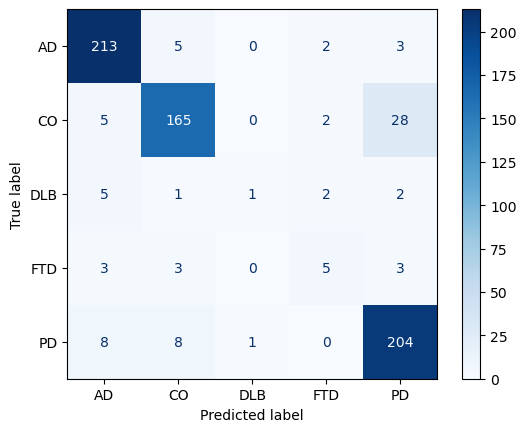

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")

In [49]:
import pandas as pd
import datetime

unique_ids = selected_data.loc[X_test.index, "UniquePhenoID"].values
current_date = datetime.datetime.now().strftime("%m%d")

class_labels = label_encoder.classes_

results_df = pd.DataFrame({
    "UniquePhenoID": unique_ids,
    "True Class": label_encoder.inverse_transform(y_test),
    "Predicted Class": label_encoder.inverse_transform(y_pred)
})

for idx, label in enumerate(class_labels):
    results_df[f"{label} Probability"] = y_pred_proba[:, idx]

file_name = f"CSF_testing_predictions_with_probabilities_{current_date}.csv"

# results_df.to_csv(file_name, index=False)
# print(f"CSV file saved as {file_name}")

(669,)


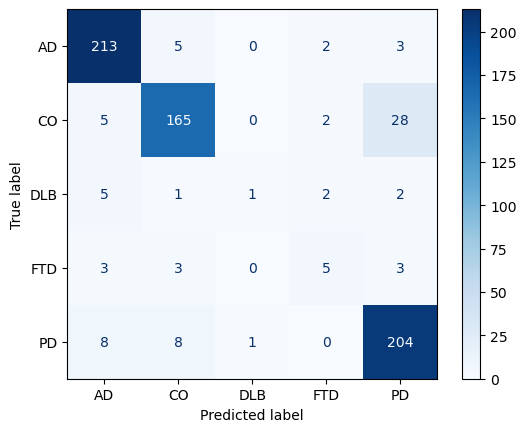


=== Confusion-matrix-derived metrics ===
  Class   TP  FN  FP   TN  Sensitivity  Specificity  Accuracy
0    AD  213  10  21  425        0.955        0.953     0.954
1    CO  165  35  17  452        0.825        0.964     0.922
2   DLB    1  10   1  657        0.091        0.998     0.984
3   FTD    5   9   6  649        0.357        0.991     0.978
4    PD  204  17  36  412        0.923        0.920     0.921


In [50]:
# ===========================================================
# ★  Multi-class Evaluation｜Confusion → TP/FN/FP/TN + ROC-AUC + Error Bars  ★
#     Dependencies:
#        y_test          – True labels (1D array)
#        y_pred          – Predicted labels from argmax
#        y_test_proba    – Predicted probability matrix (n_samples × n_classes)
#        label_encoder   – sklearn LabelEncoder, ensures consistent class order
# ===========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.utils import resample
from matplotlib.lines import Line2D

# -----------------------------------------------------------
# 0) Extract aligned labels / predictions / probabilities from results_df
# -----------------------------------------------------------
class_order = ['AD', 'CO', 'DLB', 'FTD', 'PD']
proba_cols  = [f"{c} Probability" for c in class_order]

# Keep only the five main classes & standardize to uppercase
results_df = results_df[results_df['True Class'].isin(class_order)].copy()
results_df['True Class'] = results_df['True Class'].str.upper()

# LabelEncoder (with fixed order)
label_encoder = LabelEncoder().fit(class_order)

# Regenerate 3 core variables — all aligned to len(results_df) (≈900)
y_test_lbl   = results_df['True Class'].values
y_pred_lbl   = results_df['Predicted Class'].values
y_test       = label_encoder.transform(y_test_lbl)
print(y_test.shape)
y_pred       = label_encoder.transform(y_pred_lbl)
y_test_proba = results_df[proba_cols].to_numpy()   # ★ This line is critical

class_labels = label_encoder.classes_
n_classes    = len(class_labels)
n_samples    = len(y_test_lbl)

# -----------------------------------------------------------
# 1) Confusion Matrix & Derived Metrics
# -----------------------------------------------------------
cm  = confusion_matrix(y_test_lbl, y_pred_lbl, labels=class_labels)
ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(cmap="Blues")
plt.show()

N = cm.sum()
rows = []
for idx, cls in enumerate(class_labels):
    TP = cm[idx, idx]
    FN = cm[idx, :].sum() - TP
    FP = cm[:, idx].sum() - TP
    TN = N - TP - FN - FP
    sens = TP / (TP + FN) if TP + FN else np.nan
    spec = TN / (TN + FP) if TN + FP else np.nan
    acc  = (TP + TN) / N
    rows.append(dict(Class=cls, TP=TP, FN=FN, FP=FP, TN=TN,
                     Sensitivity=round(sens, 3),
                     Specificity=round(spec, 3),
                     Accuracy=round(acc, 3)))
metrics_df = pd.DataFrame(rows)
print("\n=== Confusion-matrix-derived metrics ===")
print(metrics_df)

In [51]:
# -----------------------------------------------------------
# 2) Compute ROC-AUC (skip classes with no positive samples)
# -----------------------------------------------------------
y_test_bin = label_binarize(y_test_lbl, classes=class_labels)
fpr, tpr, roc_auc = {}, {}, {}
sample_counts     = y_test_bin.sum(axis=0)

for i, cls in enumerate(class_labels):
    if sample_counts[i] == 0:
        print(f"⚠️  No positive samples for class {cls} in test set — skipping")
        fpr[i] = tpr[i] = np.array([0, 1]); roc_auc[i] = np.nan
        continue
    fpr[i], tpr[i], _ = roc_curve(
        y_test_bin[:, i], y_test_proba[:, i]
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

# Weighted average AUC
valid      = sample_counts > 0
weights    = sample_counts[valid] / sample_counts[valid].sum()
auc_weight = np.average(
    [roc_auc[i] for i in range(n_classes) if valid[i]],
    weights=weights
)

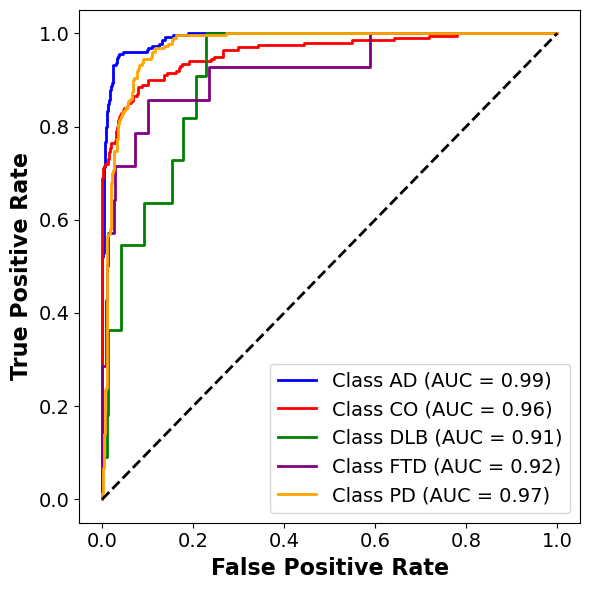

In [52]:
# -----------------------------------------------------------
# 3) Plot ROC Curves
# -----------------------------------------------------------
plt.figure(figsize=(6, 6))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    if np.isnan(roc_auc[i]):
        continue
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlabel('False Positive Rate', size=12, weight='bold')
# plt.ylabel('True Positive Rate',  size=12, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', size=16, weight='bold')
plt.ylabel('True Positive Rate',  size=16, weight='bold')
# plt.title(f'Testing Set (30%) ROC Curve (Weighted AUC={auc_weight:.2f})',
#           size=16, weight='bold')
plt.legend(loc='lower right', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

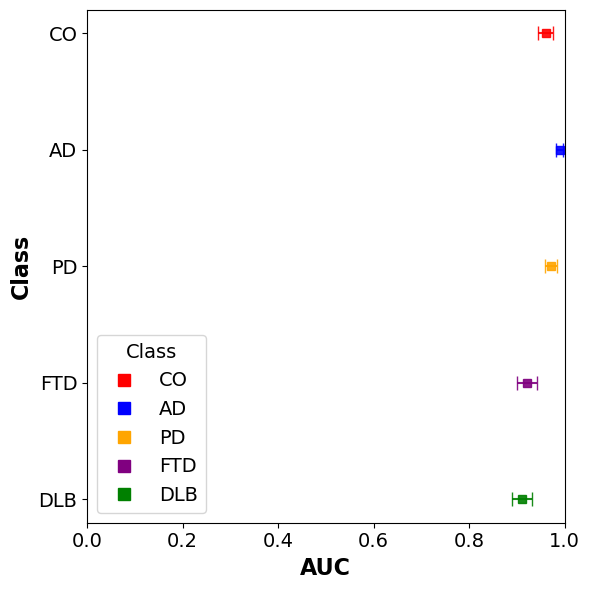

In [53]:
# -----------------------------------------------------------
# 4) AUC ± 95% Confidence Interval (Standard Error & Bootstrap with Error Bars)
# -----------------------------------------------------------
auc_rows_se, auc_rows_boot = [], []

for cls in class_labels:
    if np.sum(y_test_lbl == cls) == 0:
        continue
    idx_col = np.where(class_labels == cls)[0][0]
    
    # --- AUC value ---
    auc_val = roc_auc[idx_col]

    # --- Standard Error CI ---
    se  = np.sqrt((auc_val * (1 - auc_val)) / n_samples)
    ci_low, ci_up = auc_val - 1.96 * se, auc_val + 1.96 * se
    auc_rows_se.append([cls, auc_val, ci_low, ci_up])

    # --- Bootstrap CI (optional, slower; uncomment to use) ---
    # boots = []
    # for _ in range(1000):
    #     bs_idx = resample(np.arange(n_samples), replace=True)
    #     if np.sum(y_test_lbl[bs_idx] == cls) == 0:
    #         continue
    #     fpr_b, tpr_b, _ = roc_curve(
    #         y_test_lbl[bs_idx] == cls,
    #         y_test_proba[bs_idx, idx_col]
    #     )
    #     boots.append(auc(fpr_b, tpr_b))
    # ci_low_b = np.percentile(boots, 2.5) if boots else np.nan
    # ci_up_b  = np.percentile(boots, 97.5) if boots else np.nan
    # auc_rows_boot.append([cls, auc_val, ci_low_b, ci_up_b])

# Create dataframe of AUC ± CI (Standard Error version)
auc_df_se = pd.DataFrame(auc_rows_se, columns=['Class', 'AUC', 'CI_low', 'CI_up'])

# Set plotting order and color mapping
order     = ['CO', 'AD', 'PD', 'FTD', 'DLB']
color_map = {'AD': 'blue', 'CO': 'red', 'DLB': 'green', 'FTD': 'purple', 'PD': 'orange'}
auc_df_se['Class'] = pd.Categorical(auc_df_se['Class'], categories=order, ordered=True)
auc_df_se = auc_df_se.sort_values('Class', ascending=False)

# Plot: AUC ± 95% CI (Error bars)
plt.figure(figsize=(6, 6))
for _, r in auc_df_se.iterrows():
    plt.errorbar(r['AUC'], r['Class'],
                 xerr=[[r['AUC'] - r['CI_low']],
                       [r['CI_up'] - r['AUC']]],
                 fmt='s', color=color_map[r['Class']], capsize=5, alpha=0.9)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('AUC', size=16, weight='bold')
plt.ylabel('Class', size=16, weight='bold')
# plt.xlabel('AUC', size=16)
# plt.ylabel('Class', size=16)
# plt.title('AUC ± 95% CI', size=16, weight='bold')
plt.xlim(0, 1)
plt.grid(False)

# Custom legend
custom_lines = [Line2D([0], [0], color=color_map[c], marker='s', linestyle='',
                       markersize=8) for c in order]
plt.legend(custom_lines, order, title='Class', loc='lower left', title_fontsize=14, fontsize=14)

plt.tight_layout()
plt.show()


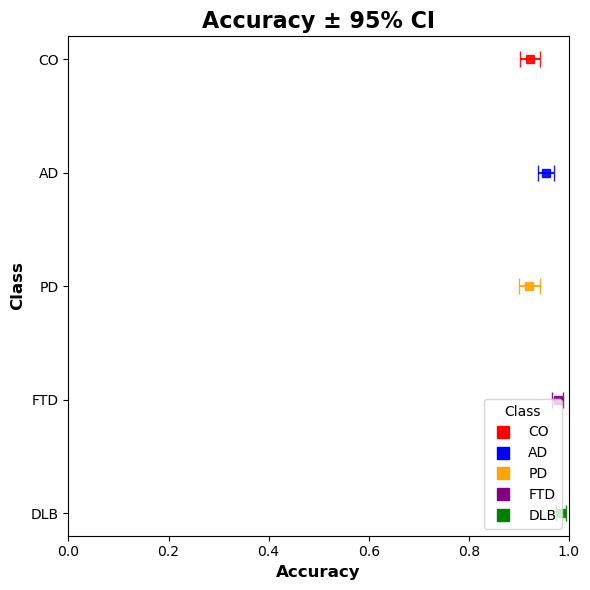

In [54]:
# -----------------------------------------------------------
# 5) Accuracy ± 95% Confidence Interval  
#     (Based on TP/FN/FP/TN → Accuracy = (TP + TN) / Total Samples)
# -----------------------------------------------------------
acc_rows = []
for cls in class_labels:
    row = metrics_df[metrics_df['Class'] == cls].iloc[0]
    TP, FN, FP, TN = row['TP'], row['FN'], row['FP'], row['TN']
    n_total = TP + FN + FP + TN          # Should equal total size of the test set (N)
    acc     = (TP + TN) / n_total
    se      = np.sqrt(acc * (1 - acc) / n_total)
    acc_rows.append([cls, acc, acc - 1.96 * se, acc + 1.96 * se])

# Create dataframe of accuracy with confidence intervals
acc_df = pd.DataFrame(acc_rows, columns=['Class', 'Accuracy', 'CI_low', 'CI_up'])

# Reorder class labels and sort for plotting
acc_df['Class'] = pd.Categorical(acc_df['Class'], categories=order, ordered=True)
acc_df = acc_df.sort_values('Class', ascending=False)

# Plot: Accuracy ± 95% CI (Error bars)
plt.figure(figsize=(6, 6))
for _, r in acc_df.iterrows():
    plt.errorbar(r['Accuracy'], r['Class'],
                 xerr=[[r['Accuracy'] - r['CI_low']],
                       [r['CI_up'] - r['Accuracy']]],
                 fmt='s', color=color_map[r['Class']], capsize=6, alpha=0.9)

plt.xlabel('Accuracy', size=12, weight='bold')
plt.ylabel('Class',   size=12, weight='bold')
plt.title('Accuracy ± 95% CI', size=16, weight='bold')
plt.xlim(0, 1)
plt.grid(False)

# Custom legend for class colors
custom_lines = [Line2D([0], [0], color=color_map[c], marker='s', linestyle='',
                       markersize=8) for c in order]
plt.legend(custom_lines, order, title='Class', loc='lower right')

plt.tight_layout()
plt.show()


In [55]:
# -----------------------------------------------------------
# 6) Print Summary Info
# -----------------------------------------------------------
print("\n=== Per-class summary ===")
for cls in class_labels:
    row = metrics_df[metrics_df['Class'] == cls].iloc[0]
    print(f"Class {cls}:")
    print(f"  AUC:         {roc_auc[class_labels.tolist().index(cls)]:.3f}")
    print(f"  Sensitivity: {row['Sensitivity']:.3f}")
    print(f"  Specificity: {row['Specificity']:.3f}")
    print(f"  Accuracy:    {row['Accuracy']:.4f}\n")


=== Per-class summary ===
Class AD:
  AUC:         0.990
  Sensitivity: 0.955
  Specificity: 0.953
  Accuracy:    0.9540

Class CO:
  AUC:         0.960
  Sensitivity: 0.825
  Specificity: 0.964
  Accuracy:    0.9220

Class DLB:
  AUC:         0.911
  Sensitivity: 0.091
  Specificity: 0.998
  Accuracy:    0.9840

Class FTD:
  AUC:         0.922
  Sensitivity: 0.357
  Specificity: 0.991
  Accuracy:    0.9780

Class PD:
  AUC:         0.972
  Sensitivity: 0.923
  Specificity: 0.920
  Accuracy:    0.9210



Class Labels: ['AD' 'CO' 'DLB' 'FTD' 'PD']


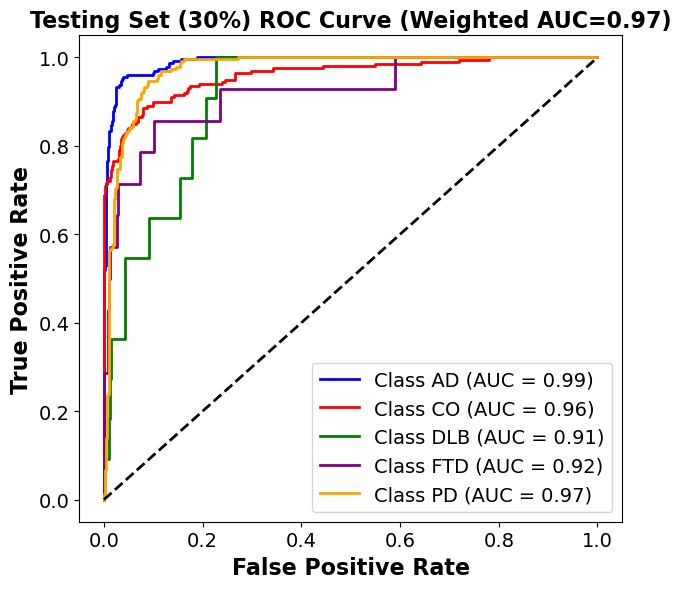

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np
import pickle

# Get class labels from encoded labels (inverse transform using label_encoder)
class_labels = label_encoder.inverse_transform(np.unique(y_encoded))
print("Class Labels:", class_labels)
n_classes = len(class_labels)

# Compute predicted probabilities for the test set
y_test_proba = lgbm_model.predict_proba(X_test)

# Initialize containers for FPR, TPR, and AUC
fpr_test, tpr_test, roc_auc_test = {}, {}, {}
all_fpr_test = np.linspace(0, 1, 100)

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Compute macro average AUC (unweighted)
roc_auc_test_macro = np.mean(list(roc_auc_test.values()))

# Plot ROC curves for the test set
plt.figure(figsize=(12, 6))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])

plt.subplot(1, 2, 2)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2,
             label=f'Class {class_labels[i]} (AUC = {roc_auc_test[i]:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize plot appearance
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', size=16, weight='bold')
plt.ylabel('True Positive Rate', size=16, weight='bold')
# Title can be either macro or weighted depending on your use
# plt.title(f'Testing Set (30%) ROC Curve (Macro AUC={roc_auc_test_macro:.2f})', size=16, weight='bold')
plt.title(f'Testing Set (30%) ROC Curve (Weighted AUC={auc_ovr_weighted:.2f})', size=16, weight='bold')
plt.legend(loc='lower right', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Save test set ROC curve results for LGBMClassifier
# -------------------------------------------------------
lgbm_roc_data = {
    "fpr_test": fpr_test,
    "tpr_test": tpr_test,
    "roc_auc_test": roc_auc_test,
    "class_labels": class_labels,
    "y_test_proba": y_test_proba,  # Save predicted probabilities
    "y_test": y_test               # Save ground truth
}

# Uncomment to save to file
# with open("csf_lgbm_roc_data.pkl", "wb") as f:
#     pickle.dump(lgbm_roc_data, f)


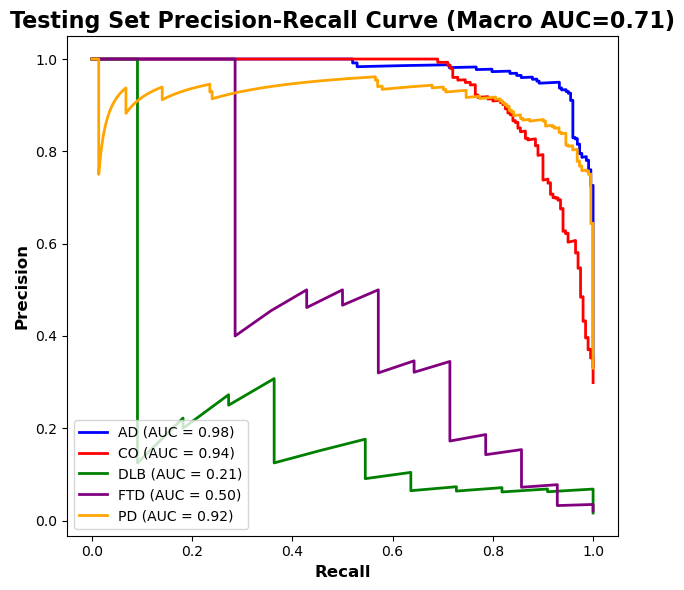

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from itertools import cycle

# Get class labels from label encoder
class_labels = label_encoder.classes_  
n_classes = len(class_labels)

# Initialize dictionaries to hold ROC and PR curve components
fpr_test, tpr_test = {}, {}
precision_test, recall_test = {}, {}
roc_auc_test, pr_auc_test = {}, {}

# Compute ROC-AUC and PR-AUC for each class (One-vs-Rest)
for i, label in enumerate(class_labels):
    y_true_binary = (y_test == i).astype(int)  # Convert to binary: current class vs. rest
    fpr_test[i], tpr_test[i], _ = roc_curve(y_true_binary, y_pred_proba[:, i])
    precision_test[i], recall_test[i], _ = precision_recall_curve(y_true_binary, y_pred_proba[:, i])
    
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    pr_auc_test[i] = auc(recall_test[i], precision_test[i])

# Compute macro average AUCs
roc_auc_test_macro = np.mean(list(roc_auc_test.values()))
pr_auc_test_macro = np.mean(list(pr_auc_test.values()))

# Plot curves
plt.figure(figsize=(12, 6))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta'])

# === ROC Curve (Optional) ===
# plt.subplot(1, 2, 1)
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2,
#              label=f'{class_labels[i]} (AUC = {roc_auc_test[i]:.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(f'Testing Set ROC Curve (Macro AUC={roc_auc_test_macro:.2f})')
# plt.legend(loc='lower right')

# === Precision-Recall Curve ===
plt.subplot(1, 2, 2)
for i, color in zip(range(n_classes), colors):
    plt.plot(recall_test[i], precision_test[i], color=color, lw=2,
             label=f'{class_labels[i]} (AUC = {pr_auc_test[i]:.2f})')

plt.xlabel('Recall', size=12, weight='bold')
plt.ylabel('Precision', size=12, weight='bold')
plt.title(f'Testing Set Precision-Recall Curve (Macro AUC={pr_auc_test_macro:.2f})', size=16, weight='bold')
plt.legend(loc='lower left')
plt.grid(False)
plt.tight_layout()
plt.show()

# Build a DataFrame to report AUROC and AUPR per class
auroc_aupr_matrix = pd.DataFrame({
    "Class": class_labels,
    "AUROC": [roc_auc_test[i] for i in range(n_classes)],
    "AUPR":  [pr_auc_test[i] for i in range(n_classes)]
})


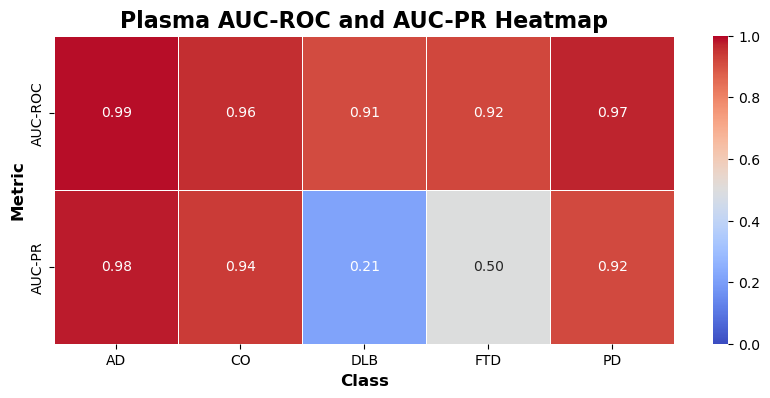

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Construct DataFrame with AUROC and AUPR values for each class
auroc_aupr_matrix = pd.DataFrame({
    "Class": class_labels,
    "AUC-ROC": [roc_auc_test[i] for i in range(n_classes)],
    "AUC-PR":  [pr_auc_test[i] for i in range(n_classes)]
}).set_index("Class")

# Transpose the DataFrame so metrics become rows, and classes become columns
auroc_aupr_matrix_transposed = auroc_aupr_matrix.T

# Set figure size
plt.figure(figsize=(10, 4))

# Draw the heatmap
sns.heatmap(
    auroc_aupr_matrix_transposed,
    annot=True,            # Annotate with numeric values
    cmap="coolwarm",       # Color palette (e.g., "viridis", "plasma", "Blues", "coolwarm")
    fmt=".2f",             # Number format for annotations
    linewidths=0.5,        # Line width between cells
    vmin=0, vmax=1         # Fix color range from 0 to 1
)

# Add title and axis labels
plt.title("Plasma AUC-ROC and AUC-PR Heatmap", size=16, weight='bold')
plt.xlabel("Class", size=12, weight='bold')
plt.ylabel("Metric", size=12, weight='bold')

# Show plot
plt.show()

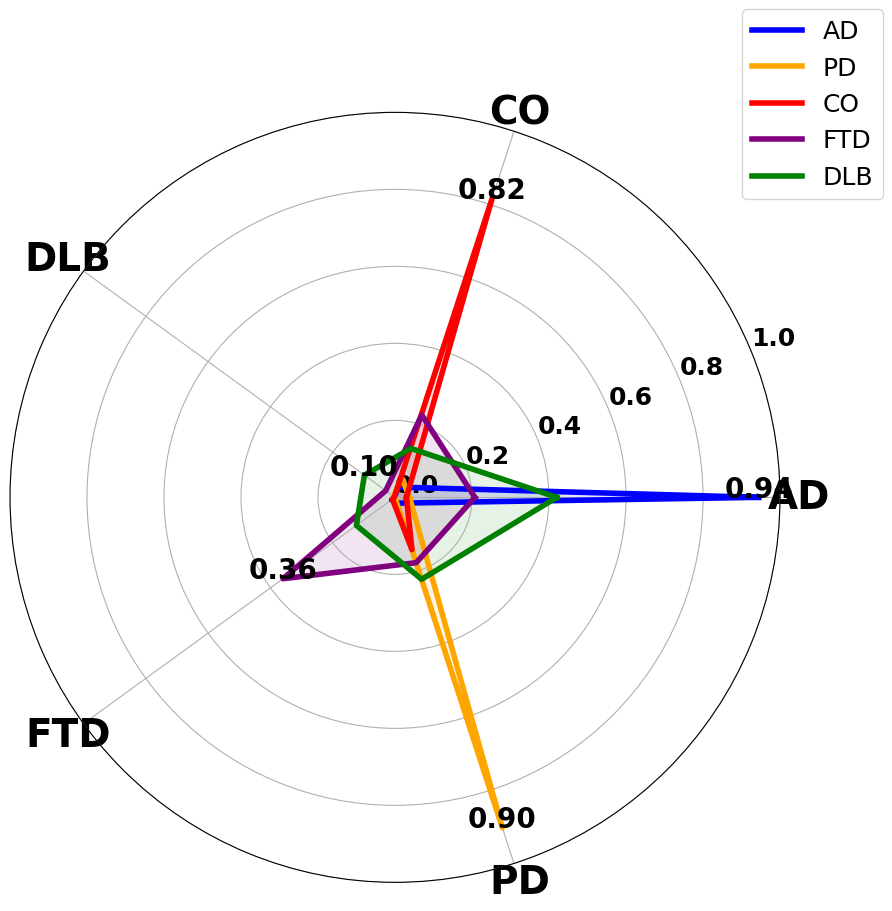

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# Color mapping for each class
color_map = {
    'AD': 'blue',
    'CO': 'red',
    'DLB': 'green',
    'FTD': 'purple',
    'PD': 'orange'
}

# Compute mean and 95% confidence interval (CI) for each class
def calculate_mean_and_ci(data, confidence=0.95):
    mean = np.mean(data, axis=0)
    se = np.std(data, axis=0) / np.sqrt(len(data))
    ci = se * 1.96  # 95% CI using normal approximation
    return mean, mean - ci, mean + ci

# Function to draw a combined radar chart for all classes
def plot_combined_radar_chart(means, labels, class_names):
    labels = [col.replace(' Probability', '') for col in results_df.columns if 'Probability' in col]
    num_vars = len(labels)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Close the radar chart loop
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for i, mean in enumerate(means):
        class_name = class_names[i]
        color = color_map.get(class_name, 'gray')
        mean_values = list(mean) + [mean[0]]  # Close the polygon
        ax.plot(angles, mean_values, label=class_name, linewidth=4, color=color)
        ax.fill(angles, mean_values, alpha=0.1, color=color)
    
    # Annotate the max value for each axis dimension
    for j in range(num_vars):
        max_value = max([means[i][j] for i in range(len(means))])
        ax.text(angles[j], max_value, f'{max_value:.2f}', 
                horizontalalignment='center', size=20, color='black', fontweight='bold')
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=28, fontweight='bold') 
    ax.set_yticklabels([])

    # ax.set_title("Radar Plot of 5 Main Status", size=30, weight='bold')
    # ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15), fontsize=18,
    #           title="True Class", title_fontsize=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15), fontsize=18, title_fontsize=20)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=18, fontweight='bold')
    
    plt.show()

# === Compute mean probabilities for each class ===
true_classes = ['AD', 'PD', 'CO', 'FTD', 'DLB']
probability_columns = [col for col in results_df.columns if 'Probability' in col]

means = []
for true_class in true_classes:
    subset = results_df[results_df['True Class'] == true_class]
    probabilities = subset[probability_columns].values
    mean, _, _ = calculate_mean_and_ci(probabilities)
    means.append(mean)

# === Generate radar plot ===
plot_combined_radar_chart(means, probability_columns, true_classes)
